## 1 Overview

- **Main ideas:**
    - This notebook makes the `GLEAM` surface soil moisture (daily) spatially compatible with `ERA-INTERIM` data grid: 
        - GLEAM:
            - lat: 720, lon: 1440; 0.25 x 0.25 degrees; global.
        - ERA-INTERIM: 
            - lat: 241, lon: 480; 0.75 x 0.75 degrees; global. 

## 2 Initial setup

In [1]:
# Load packages
import sys
import glob
import os
import warnings

import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dask.diagnostics import ProgressBar

warnings.filterwarnings("ignore")
xr.set_options(display_style="text")

%matplotlib inline

In [2]:
print("Python:", sys.version)
print("Xarray:", xr.__version__)
print("Pandas:", pd.__version__)

Python: 3.7.7 (default, Mar 26 2020, 15:48:22) 
[GCC 7.3.0]
Xarray: 0.16.0
Pandas: 1.0.2


In [3]:
# My repository.
repository = "/home/alex/Dropbox/repositories/cdlearn/"

In [4]:
# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Work in progress.
from cdlearn.maps import south_america_months

In [5]:
# Data folder.
MAIN_FOLDER = "/media/alex/ALEXDATA/data_sets/GLEAM/v3.3a/daily/"

# Put regridded data here.
OUTPUT_FOLDER = "/media/alex/ALEXDATA/data_sets/GLEAM/v3.3a/daily/regridded/"

# Year in a folder.
ANNUAL_DATA_FOLDERS = sorted(
    [os.path.join(MAIN_FOLDER, YEAR) for YEAR in os.listdir(MAIN_FOLDER)]
) 

In [6]:
# South America.
loni, lonf, lati, latf = -90, -30, -60, 20

## 3 Explore single file

In [7]:
# First time steps for data of surface soil moisture. 
FILE_PATH = os.path.join(ANNUAL_DATA_FOLDERS[0], "SMsurf_1980_GLEAM_v3.3a.nc")

# Lazy load. The chunks option make data as dask arrays instead of numpy arrays.
# So when transposing the data is not loaded into memory!
DS = xr.open_dataset(FILE_PATH, chunks={})

# Now you can transpose without loading into memory.
DS = DS.transpose("time", "lat", "lon")

# Show it.
print(DS.SMsurf)

<xarray.DataArray 'SMsurf' (time: 366, lat: 720, lon: 1440)>
dask.array<transpose, shape=(366, 720, 1440), dtype=float64, chunksize=(366, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
Attributes:
    units:          m3/m3
    long_name:      Surface soil moisture
    standard_name:  Surface soil moisture


In [8]:
# Into memory.
with ProgressBar():
    DS = DS.load()

[########################################] | 100% Completed |  9.1s


## 4 Create regridder file

In [9]:
# In accordance with ERA-INTERIM pos-processed data (after shifting longitudes from 0 ... 360
# to -180 ... 180).
NEW_GRID = xr.Dataset({
    "lat": (["lat"], np.arange(90.00, -90.01, -0.75)),
    "lon": (["lon"], np.arange(-180.00, 180.00, 0.75)),
})

# Show it.
print(NEW_GRID)

<xarray.Dataset>
Dimensions:  (lat: 241, lon: 480)
Coordinates:
  * lat      (lat) float64 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
  * lon      (lon) float64 -180.0 -179.2 -178.5 -177.8 ... 177.8 178.5 179.2
Data variables:
    *empty*


In [10]:
%%time

# Regridder object.
REGRIDDER = xe.Regridder(
    ds_in=DS, 
    ds_out=NEW_GRID, 
    method="bilinear", 
    periodic=True, 
    reuse_weights=True,
    filename="ssm_regridder.nc"
)

Reuse existing file: ssm_regridder.nc
CPU times: user 35.8 ms, sys: 28.1 ms, total: 63.8 ms
Wall time: 63.4 ms


In [11]:
%%time

# Regridded data.
DSreg = REGRIDDER(DS)

# Show it.
print(DSreg)

using dimensions ('lat', 'lon') from data variable SMsurf as the horizontal dimensions for this dataset.
<xarray.Dataset>
Dimensions:  (lat: 241, lon: 480, time: 366)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * lon      (lon) float64 -180.0 -179.2 -178.5 -177.8 ... 177.8 178.5 179.2
  * lat      (lat) float64 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
Data variables:
    SMsurf   (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    regrid_method:  bilinear
CPU times: user 2.87 s, sys: 555 ms, total: 3.42 s
Wall time: 3.46 s


## 5 Compare original and regridded files

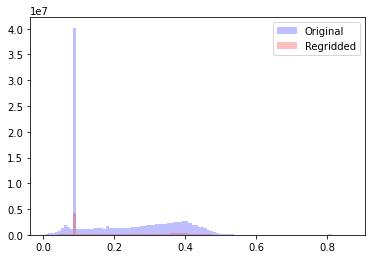

In [12]:
# Histograms.
plt.hist(DS.SMsurf.values.flatten(), bins=100, color="blue", alpha=0.25, label="Original")
plt.hist(DSreg.SMsurf.values.flatten(), bins=100, color="red", alpha=0.25, label="Regridded")
plt.legend();

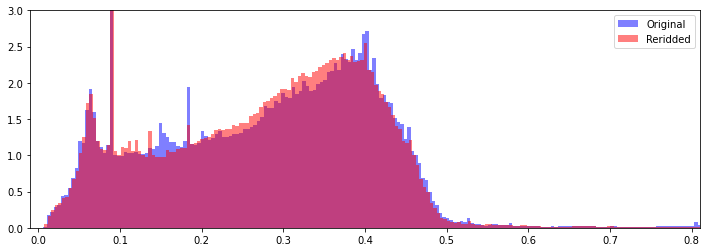

In [13]:
# Histograms.
plt.figure(figsize=(12, 4))
plt.hist(
    DS.SMsurf.values.flatten(), 
    density=True, 
    bins=200, 
    color="blue", 
    alpha=0.5, 
    label="Original"
)
plt.hist(
    DSreg.SMsurf.values.flatten(), 
    density=True, 
    bins=200, 
    color="red", 
    alpha=0.5, 
    label="Reridded"
)
plt.ylim((0, 3))
plt.xlim((-0.01, 0.81))
plt.legend();

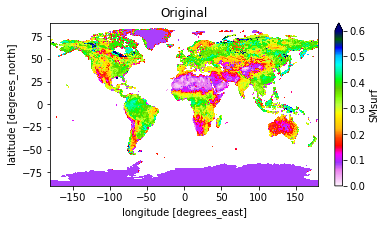

In [14]:
# Mean for the first year.
plt.figure(figsize=(6, 3))
DS.SMsurf.mean("time").plot(vmin=0, vmax=0.6, cmap=plt.cm.gist_ncar_r)
plt.title("Original");

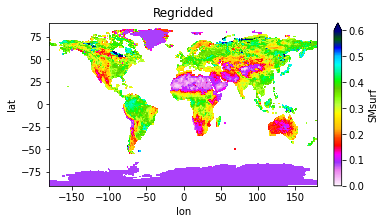

In [15]:
# Mean for the first year.
plt.figure(figsize=(6, 3))
DSreg.SMsurf.mean("time").plot(vmin=0, vmax=0.6, cmap=plt.cm.gist_ncar_r)
plt.title("Regridded");

## 6 Create regridded files for all years

In [16]:
%%time

# All original files.
FILES_PATHS = sorted([
    os.path.join(FOLDER, FILE) for FOLDER in ANNUAL_DATA_FOLDERS 
         for FILE in os.listdir(FOLDER)
         if "SMsurf" in FILE
])

# Loop over input files.
for FILE_PATH in FILES_PATHS:
    
    # Extract input file name without extension.
    NAME = os.path.basename(FILE_PATH) # File name with extension.
    NAME = os.path.splitext(NAME)[0] # File name withou extension.
    
    # Output file path.
    OUT_FILE_NAME = NAME + "_regridded" + ".nc4"
    OUT_FILE_PATH = OUTPUT_FOLDER + OUT_FILE_NAME   
    
    # Continue only if data file does not exist yet.
    if not os.path.isfile(OUT_FILE_PATH):
        
        # Message.
        print("Creating", OUT_FILE_PATH, "...")
        
        # Read data.
        DS = xr.open_dataset(FILE_PATH, chunks={})
        
        # Transpose dimensions.
        DS = DS.transpose("time", "lat", "lon")
              
        # Regrid NDVI data.
        DSreg = REGRIDDER(DS)
    
        # Export regridded data into the output folder. 
        DSreg.to_netcdf(path=OUT_FILE_PATH)

Creating /media/alex/ALEXDATA/data_sets/GLEAM/v3.3a/daily/regridded/SMsurf_1980_GLEAM_v3.3a_regridded.nc4 ...
using dimensions ('lat', 'lon') from data variable SMsurf as the horizontal dimensions for this dataset.
Creating /media/alex/ALEXDATA/data_sets/GLEAM/v3.3a/daily/regridded/SMsurf_1981_GLEAM_v3.3a_regridded.nc4 ...
using dimensions ('lat', 'lon') from data variable SMsurf as the horizontal dimensions for this dataset.
Creating /media/alex/ALEXDATA/data_sets/GLEAM/v3.3a/daily/regridded/SMsurf_1982_GLEAM_v3.3a_regridded.nc4 ...
using dimensions ('lat', 'lon') from data variable SMsurf as the horizontal dimensions for this dataset.
Creating /media/alex/ALEXDATA/data_sets/GLEAM/v3.3a/daily/regridded/SMsurf_1983_GLEAM_v3.3a_regridded.nc4 ...
using dimensions ('lat', 'lon') from data variable SMsurf as the horizontal dimensions for this dataset.
Creating /media/alex/ALEXDATA/data_sets/GLEAM/v3.3a/daily/regridded/SMsurf_1984_GLEAM_v3.3a_regridded.nc4 ...
using dimensions ('lat', 'lon'